In [1]:
import json
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
# Load the sarcasm data set
with open('sarcasm.json', 'r') as file:
    datafile = json.load(file)

sentences = []
labels = []

In [4]:
type(datafile)

list

In [5]:
len(datafile)

26709

In [6]:
print(datafile[0:4])

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}, {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365', 'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse", 'is_sarcastic': 0}, {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697', 'headline': "mom starting to fear son's web series closest thing she will have to grandchild", 'is_sarcastic': 1}, {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302', 'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'is_sarcastic': 1}]


In [7]:
# Extract data from the file to the arrays
for item in datafile:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
# Sanity check
print(len(sentences), len(labels))

26709 26709


In [9]:
# Params and hyper params
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [10]:
# Spiting into train and test sets
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [11]:
# Converting label lists to numpy arrays
import numpy as np
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [12]:
# Sanity check
print(len(training_sentences), len(testing_sentences), len(training_labels), len(testing_labels))

20000 6709 20000 6709


In [13]:
# Tokenizing
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [14]:
# Sanity check
print(len(training_padded), len(testing_padded))

20000 6709


In [15]:
# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [16]:
# Compiling the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Training the model
num_epochs = 20
history = model.fit(training_padded,
training_labels,
epochs = num_epochs,
validation_data = (testing_padded, testing_labels))

Epoch 1/20
625/625 [==============================] - 4s 7ms/step - loss: 0.6596 - accuracy: 0.5892 - val_loss: 0.5723 - val_accuracy: 0.7828
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.4331 - accuracy: 0.8322 - val_loss: 0.3868 - val_accuracy: 0.8432
Epoch 3/20
625/625 [==============================] - 6s 10ms/step - loss: 0.3107 - accuracy: 0.8784 - val_loss: 0.3549 - val_accuracy: 0.8508
Epoch 4/20
625/625 [==============================] - 3s 4ms/step - loss: 0.2570 - accuracy: 0.9013 - val_loss: 0.3502 - val_accuracy: 0.8498
Epoch 5/20
625/625 [==============================] - 8s 13ms/step - loss: 0.2204 - accuracy: 0.9162 - val_loss: 0.3443 - val_accuracy: 0.8553
Epoch 6/20
625/625 [==============================] - 8s 13ms/step - loss: 0.1917 - accuracy: 0.9281 - val_loss: 0.3560 - val_accuracy: 0.8551
Epoch 7/20
625/625 [==============================] - 8s 12ms/step - loss: 0.1709 - accuracy: 0.9365 - val_loss: 0.3784 - val_accuracy: 0.8481
E

In [18]:
# Plotting the results
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()


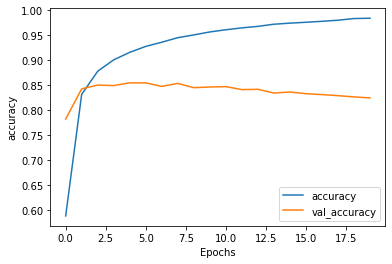

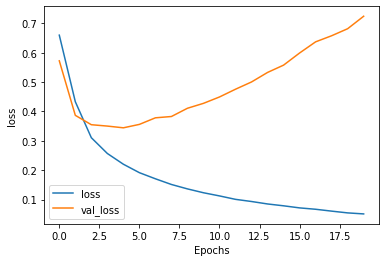

In [19]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
# model with LTSM
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [21]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
history = model2.fit(
training_padded,
training_labels,
epochs = num_epochs,
validation_data = (testing_padded, testing_labels)
)

Epoch 1/20
625/625 [==============================] - 59s 94ms/step - loss: 0.4109 - accuracy: 0.8007 - val_loss: 0.3325 - val_accuracy: 0.8551
Epoch 2/20
625/625 [==============================] - 61s 97ms/step - loss: 0.2109 - accuracy: 0.9164 - val_loss: 0.3541 - val_accuracy: 0.8545
Epoch 3/20
625/625 [==============================] - 63s 100ms/step - loss: 0.1283 - accuracy: 0.9529 - val_loss: 0.3773 - val_accuracy: 0.8520
Epoch 4/20
625/625 [==============================] - 63s 101ms/step - loss: 0.0760 - accuracy: 0.9748 - val_loss: 0.4826 - val_accuracy: 0.8480
Epoch 5/20
625/625 [==============================] - 37s 60ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.6068 - val_accuracy: 0.8433
Epoch 6/20
625/625 [==============================] - 49s 79ms/step - loss: 0.0309 - accuracy: 0.9901 - val_loss: 0.6900 - val_accuracy: 0.8359
Epoch 7/20
625/625 [==============================] - 61s 97ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.8937 - val_accurac

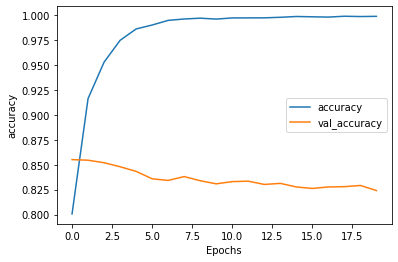

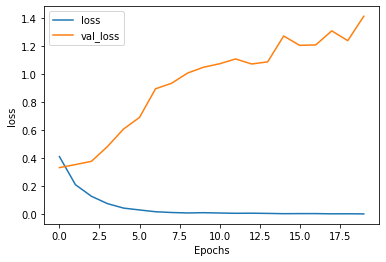

In [23]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [24]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [25]:
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
history = model3.fit(
training_padded,
training_labels,
epochs = num_epochs,
validation_data = (testing_padded, testing_labels)
)

Epoch 1/20
625/625 [==============================] - 16s 25ms/step - loss: 0.4377 - accuracy: 0.7821 - val_loss: 0.3497 - val_accuracy: 0.8481
Epoch 2/20
625/625 [==============================] - 16s 25ms/step - loss: 0.2217 - accuracy: 0.9118 - val_loss: 0.3863 - val_accuracy: 0.8459
Epoch 3/20
625/625 [==============================] - 15s 25ms/step - loss: 0.1050 - accuracy: 0.9636 - val_loss: 0.4326 - val_accuracy: 0.8453
Epoch 4/20
625/625 [==============================] - 15s 25ms/step - loss: 0.0390 - accuracy: 0.9887 - val_loss: 0.6122 - val_accuracy: 0.8432
Epoch 5/20
625/625 [==============================] - 15s 24ms/step - loss: 0.0121 - accuracy: 0.9970 - val_loss: 0.7494 - val_accuracy: 0.8386
Epoch 6/20
625/625 [==============================] - 15s 24ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.8196 - val_accuracy: 0.8389
Epoch 7/20
625/625 [==============================] - 15s 24ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.9053 - val_accuracy:

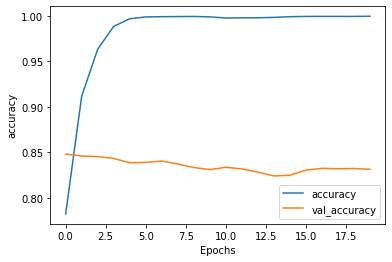

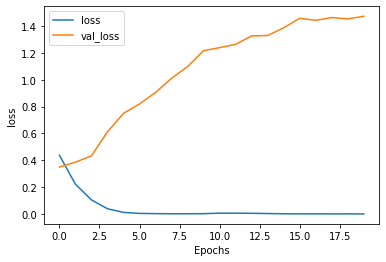

In [27]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")